In [1]:
# import libraries and packages

import random
import matplotlib.pyplot as plt
import numpy as np
import configparser
import pandas as pd

In [2]:
# cd to lenstronomy location
%cd /Users/genebelinario/Documents/dnc_research/thesis/notebooks
!ls

/Users/genebelinario/Documents/dnc_research/thesis/notebooks
LOSC_Event_tutorial-master lenstronomy_solver.ipynb
lensed_gw.ipynb            near_source.ipynb
lensed_unlensed_gw.ipynb   plots.ipynb
lensinggw                  source_0.png
lensinggw_setup.ipynb      source_1.png
lenstronomy                source_2.png


In [3]:
# install lenstronomy
#!git clone https://github.com/gipagano/lenstronomy.git
%cd /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lenstronomy
!ls

/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lenstronomy
AFFILIATEDPACKAGES.rst MANIFEST.in            setup.cfg
AUTHORS.rst            Makefile               setup.py
CONTRIBUTING.rst       PUBLISHED.rst          test
Gemfile                README.rst             test_helper.rb
HISTORY.rst            docs                   tox.ini
LICENSE                lenstronomy
MAILINGLIST.rst        requirements.txt


In [15]:
# coordinates, first define them in scaled units [x (radians) /thetaE_tot]
y0,y1 = 0.1,0.5*np.sqrt(3)   
l0,l1 = 0.5,0  

# redshifts                                                                                                                  
zS = 2.0 
zL = 0.5  

# masses 
mL1  = 100                                                                   
mL2  = 100  
mtot = mL1+mL2  

# convert to radians
from lensinggw.utils.utils import param_processing

thetaE1 = param_processing(zL, zS, mL1)                                                                                                                              
thetaE2 = param_processing(zL, zS, mL2)                                                                                                                              
thetaE  = param_processing(zL, zS, mtot)    

beta0,beta1 = y0*thetaE,y1*thetaE                                                 
eta10,eta11 = l0*thetaE,l1*thetaE                                                                                                
eta20,eta21 = -l0*thetaE,l1*thetaE  

# lens model
lens_model_list     = ['POINT_MASS', 'POINT_MASS'] 
kwargs_point_mass_1 = {'center_x': eta10,'center_y': eta11, 'theta_E': thetaE1} 
kwargs_point_mass_2 = {'center_x': eta20,'center_y': eta21, 'theta_E': thetaE2} 
kwargs_lens_list    = [kwargs_point_mass_1, kwargs_point_mass_2]   

# indicate the first lens as macromodel and solve with the two-step procedure
from lensinggw.solver.images import microimages

solver_kwargs = {'SearchWindowMacro': 4*thetaE1,
                 'SearchWindow'     : 4*thetaE2}   

Img_ra, Img_dec, MacroImg_ra, MacroImg_dec, pixel_width  = microimages(source_pos_x    = beta0,
                                                                       source_pos_y    = beta1,
                                                                       lens_model_list = lens_model_list,
                                                                       kwargs_lens     = kwargs_lens_list,
                                                                       **solver_kwargs)                                                            
                                                                       
# time delays, magnifications, Morse indices and amplification factor
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification

tds = TimeDelay(Img_ra, Img_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)                
mus = magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
ns  = getMinMaxSaddle(Img_ra, Img_dec, lens_model_list, kwargs_lens_list) 
                
print('Time delays (seconds): ', tds)
print('magnifications: ',  mus)
print('Morse indices: ',ns)

dummy_frequencies = np.linspace(0,10,11)
F = geometricalOpticsMagnification(dummy_frequencies,
                                   Img_ra,Img_dec,
                                   beta0,beta1,
                                   zL,zS,
                                   lens_model_list,
                                   kwargs_lens_list)

print('Geometrical optics amplification factor:', F)



---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> False
Scaled            --> False
SearchWindowMacro --> 3.9235258041177455e-10
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-15
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-7.99679058e-12  9.12273416e-11]
dec: [ 1.67479750e-10 -4.73467976e-11]


---- Solver settings ----

The complete model analysis will be performed with the following settings:

Scaled         --> False
OnlyMacro      --> False
MacroIndex     --> [0]
ImgIndex       --> None
SearchWindow   --> 3.9235258041177455e-10
Pixels         --> 1000
OverlapDist    --> 1e-15
PrecisionLimit --> 1e-20
Optimization   --> False
Verbose        --> False




IMAGES OF THE COMPLETE MODEL

ra: [ 2.06184855e-11  6.74286421e-11 -8.55036309e-11]
dec: [ 2.04174704e-10 -6.17971410e-11 -5.67605886e-11]

Time delays (seconds):  [0

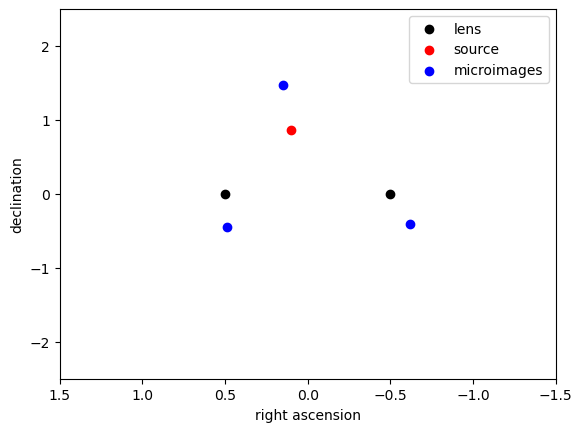

In [62]:
plt.scatter([l0, -l0], [0,0], label='lens', color='black')
plt.scatter(y0, y1, label='source', color='red')
#plt.scatter(np.array(MacroImg_ra)/thetaE, np.array(MacroImg_dec)/thetaE, color='purple', label='macroimages')
plt.scatter(np.array(Img_ra)/thetaE, np.array(Img_dec)/thetaE, color = 'blue', label='microimages')

plt.xlabel('right ascension')
plt.ylabel('declination')
plt.xlim([1.5, -1.5])
plt.ylim([-2.5,2.5])
plt.legend()
plt.show()

In [35]:
# generate unlensed GW signal 

# This script illustrates how to use lensingGW's unlensed waveform routines

from lensinggw.waveform.waveform import gw_signal

# read the waveform parameters
config_file = '/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/ini_files/waveform_config.ini'

# instantiate the waveform model
waveform_model = gw_signal(config_file)

# compute the unlensed waveform polarizations, strains in the requested detectors and their frequencies
freqs, hp_tilde, hc_tilde, strain_dict = waveform_model.unlensed_gw()

# and their signal-to-noise-ratios
SNR_dict = waveform_model.unlensed_snr()

# access an unlensed strain
sH1 = strain_dict['H1']



---- Will simulate a signal with the following parameters ----

m1          --> 11.486984
m2          --> 11.486984
spin1x      --> 0.0
spin1y      --> 0.0
spin1z      --> 0.0
spin2x      --> 0.0
spin2y      --> 0.0
spin2z      --> 0.0
distance    --> 15521.788104196934
ra          --> 1.39e-11
dec         --> 1.2e-10
psi         --> 0.0
inclination --> 2.6
phi0        --> 0.0
lambda1     --> 0.0
lambda2     --> 0.0


---- Will use the following setup ----

flow          --> 20.0
fhigh         --> 1024
fref          --> 20.0
df            --> 0.125
sampling-rate --> 2048
approximant   --> IMRPhenomPv2
amp_order     --> 0
phase_order   --> -1
starttime     --> -7.0
trigtime      --> 0.0


---- Will simulate the signal in the following detectors ----

H1     --> True
H1-psd --> /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat


Unlensed SNR in H1 = 0.70
Network SNR of the unlensed simulation 0.703994



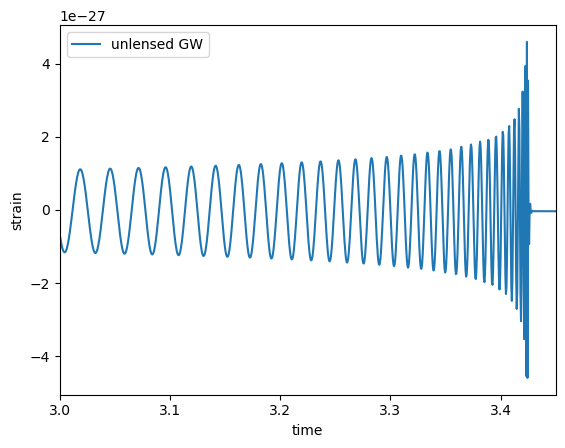

In [63]:
n = 8033 #no of frequencies
fs = 2048 #sampling rate

time_axis = np.arange(0, n/fs, 1/fs)

plt.plot(time_axis, np.fft.ifft(sH1), label='unlensed GW')

plt.xlim([3,3.45])
plt.xlabel('time')
plt.ylabel('strain')
plt.legend()
plt.show()

In [64]:
# This script illustrates how to use lensingGW's lensed waveform routines
import numpy as np

######################
# lens configuration #
######################

# source position, in radians
beta0, beta1 = 1.38717585112603e-11, 1.2013295265914425e-10

# redshifts
zL, zS = 0.5, 2.0

# binary point mass lens model
lens_model_list     = ['POINT_MASS', 'POINT_MASS'] 
kwargs_point_mass_1 = {'center_x': 6.93587925563015e-11,'center_y': 0.0, 'theta_E': 9.808814510294364e-11} 
kwargs_point_mass_2 = {'center_x': -6.93587925563015e-11,'center_y': 0.0, 'theta_E': 9.808814510294364e-11} 
kwargs_lens_list    = [kwargs_point_mass_1, kwargs_point_mass_2]

# binary point mass images, in radians
ra  = np.array([2.06184855e-11,  6.74286421e-11, -8.55036309e-11])
dec = np.array([2.04174704e-10, -6.17971410e-11, -5.67605886e-11])

####################
# lensed waveforms #
####################

from lensinggw.waveform.waveform import gw_signal

# read the waveform parameters
config_file = '/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/ini_files/waveform_config.ini'

# instantiate the waveform model
waveform_model = gw_signal(config_file)

# compute the lensed waveform polarizations, strains in the requested detectors and their frequencies
freqs_lensed, hp_tilde_lensed, hc_tilde_lensed, lensed_strain_dict = waveform_model.lensed_gw(ra,dec,
                                                                                              beta0,beta1,
                                                                                              zL, zS,
                                                                                              lens_model_list,
                                                                                              kwargs_lens_list)

# and their signal-to-noise-ratios
lensed_SNR_dict = waveform_model.lensed_snr(ra,dec,
                                            beta0,beta1,
                                            zL, zS,
                                            lens_model_list,
                                            kwargs_lens_list)

# access a lensed strain
lensed_sH1 = lensed_strain_dict['H1']



---- Will simulate a signal with the following parameters ----

m1          --> 11.486984
m2          --> 11.486984
spin1x      --> 0.0
spin1y      --> 0.0
spin1z      --> 0.0
spin2x      --> 0.0
spin2y      --> 0.0
spin2z      --> 0.0
distance    --> 15521.788104196934
ra          --> 1.39e-11
dec         --> 1.2e-10
psi         --> 0.0
inclination --> 2.6
phi0        --> 0.0
lambda1     --> 0.0
lambda2     --> 0.0


---- Will use the following setup ----

flow          --> 20.0
fhigh         --> 1024
fref          --> 20.0
df            --> 0.125
sampling-rate --> 2048
approximant   --> IMRPhenomPv2
amp_order     --> 0
phase_order   --> -1
starttime     --> -7.0
trigtime      --> 0.0


---- Will simulate the signal in the following detectors ----

H1     --> True
H1-psd --> /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat


Lensed SNR in H1 = 1.03
Network SNR of the lensed simulation 1.032217



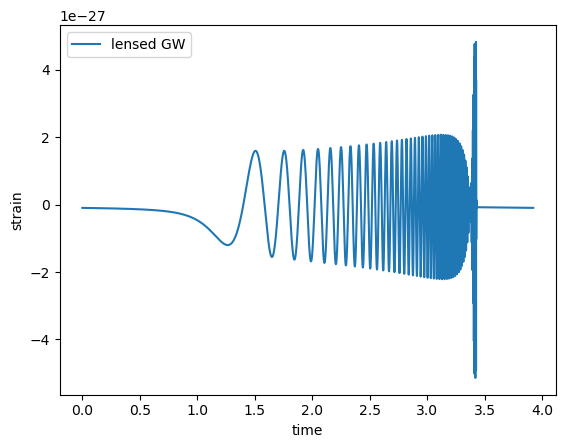

In [44]:
n = 8033 #no of frequencies
fs = 2048 #sampling rate

time_axis = np.arange(0, n/fs, 1/fs)

plt.plot(time_axis, np.fft.ifft(lensed_sH1), label='lensed GW')

plt.xlabel('time')
plt.ylabel('strain')
plt.legend()
plt.show()

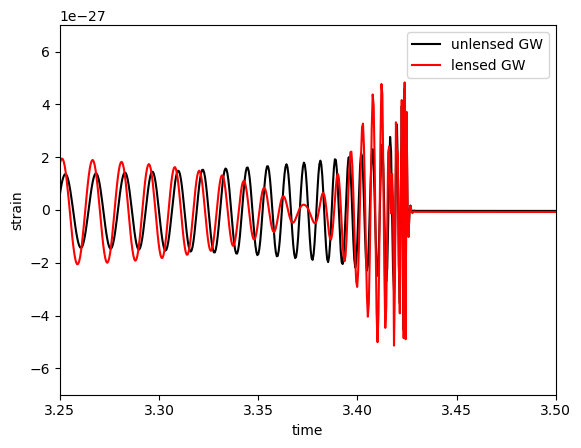

In [66]:
# compare unlensed and lensed GW signals

n = 8033 #no of frequencies
fs = 2048 #sampling rate

time_axis = np.arange(0, n/fs, 1/fs)

plt.plot(time_axis, np.fft.ifft(sH1), label='unlensed GW', color='black')
plt.plot(time_axis, np.fft.ifft(lensed_sH1), label='lensed GW', color='red')

plt.xlim([3.25, 3.5])
plt.ylim([-7e-27,7e-27])
plt.xlabel('time')
plt.ylabel('strain')
plt.legend()
plt.show()